# K-fold Neural Network Demo: Uncertainty Quantification

This notebook demonstrates the **K-fold Neural Network (KfoldNN)** for uncertainty quantification in regression problems.

## What is K-fold NN?

Traditional neural networks provide point predictions without uncertainty estimates. The K-fold NN addresses this by:

1. **Training an ensemble**: The final layer has multiple output neurons (e.g., 20-30)
2. **Data folding**: Each output neuron is trained on a different subset of the data
3. **Uncertainty from diversity**: The spread of predictions across neurons provides uncertainty estimates

### Key Hyperparameter: `xtrain`

- **`xtrain`** controls the fraction of data each output neuron sees
- **Small xtrain (0.1)**: Each neuron sees 10% of data → diverse predictions → wider uncertainty
- **Large xtrain (1.0)**: Each neuron sees all data → similar predictions → narrow uncertainty

### Use Cases

- Detecting when model is extrapolating (uncertainty increases outside training domain)
- Active learning (sample where uncertainty is high)
- Safe decision-making (avoid high-uncertainty regions)
- Model comparison and validation

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from pycse.sklearn.kfoldnn import KfoldNN

# Set random seed for reproducibility
np.random.seed(42)
print("JAX version:", jax.__version__)

JAX version: 0.8.0


## Example 1: Basic Usage - Noisy Cubic Root Function

Let's start with a simple 1D regression problem to understand the basics.

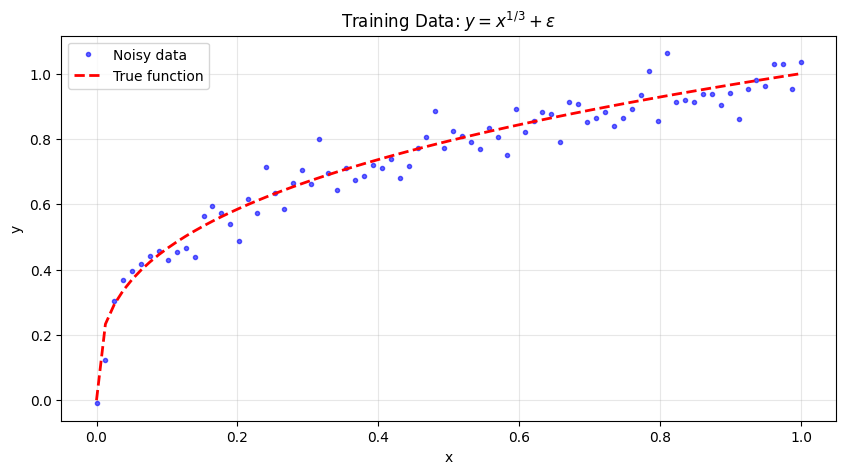

In [2]:
# Generate noisy data: y = x^(1/3) + noise
key = jax.random.PRNGKey(42)
x = jnp.linspace(0, 1, 80)[:, None]
y_true = x ** (1 / 3)
y = y_true + 0.05 * jax.random.normal(key, x.shape)
y = y.flatten()

# Visualize the data
plt.figure(figsize=(10, 5))
plt.plot(x, y, "b.", alpha=0.6, label="Noisy data")
plt.plot(x, y_true, "r--", linewidth=2, label="True function")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training Data: $y = x^{1/3} + \\epsilon$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
# Create and train K-fold NN
# Architecture: 1 input, 15 hidden neurons, 25 output neurons (k=25 ensemble)
model = KfoldNN(layers=(1, 15, 25), xtrain=0.1, seed=42)

print("Before fitting:")
print(model)
print()

# Train the model
model.fit(x, y, maxiter=800, tol=1e-4)

print("\nAfter fitting:")
print(model)
print()

# Print training report
info = model.report()
print(f"\nConverged: {info['converged']}")

Before fitting:
K-fold Neural Network (not fitted)
  Architecture: (1, 15, 25)
  Hidden layers: 2
  Output neurons: 25
  Training fraction: 0.10


After fitting:
K-fold Neural Network (fitted)
  Architecture: (1, 15, 25)
  Hidden layers: 2
  Output neurons: 25
  Training fraction: 0.10
  Iterations: 800
  Final loss: 0.084131

Iterations: 800, Loss: 0.084131

Converged: False


In [4]:
# Make predictions with uncertainty
x_test = jnp.array([[0.25], [0.5], [0.75]])
y_pred, y_std = model.predict(x_test, return_std=True)

print("Predictions with 95% confidence intervals:")
for i, xi in enumerate(x_test):
    print(f"  x={xi[0]:.2f}: {y_pred[i]:.4f} ± {2 * y_std[i]:.4f}")

Predictions with 95% confidence intervals:
  x=0.25: 0.5925 ± 0.0757
  x=0.50: 0.7839 ± 0.0329
  x=0.75: 0.9005 ± 0.0398


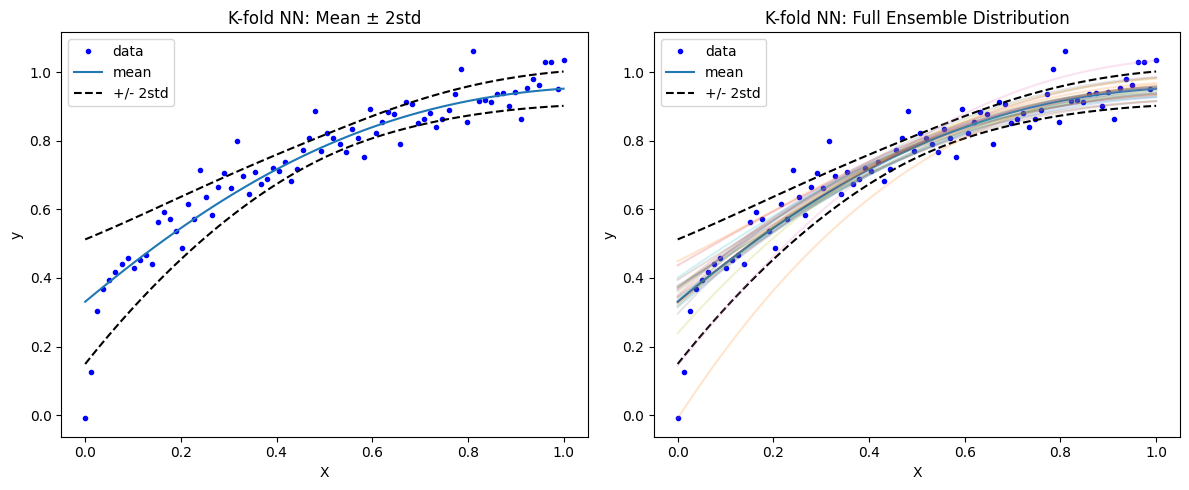

In [5]:
# Visualize predictions with uncertainty
plt.figure(figsize=(12, 5))

# Plot 1: With uncertainty bands
plt.subplot(1, 2, 1)
fig = model.plot(x, y, distribution=False)
plt.title("K-fold NN: Mean ± 2std")

# Plot 2: With full distribution
plt.subplot(1, 2, 2)
fig = model.plot(x, y, distribution=True)
plt.title("K-fold NN: Full Ensemble Distribution")

plt.tight_layout()
plt.show()

In [6]:
# Evaluate model performance
r2_score = model.score(x, y)
print(f"R² score on training data: {r2_score:.4f}")

# Compute MAE
y_pred_train = model.predict(x)
mae = jnp.mean(jnp.abs(y_pred_train - y))
print(f"Mean Absolute Error: {mae:.4f}")

R² score on training data: 0.8987
Mean Absolute Error: 0.0430


## Example 2: Understanding the `xtrain` Parameter

The `xtrain` parameter controls how much data each output neuron sees, which directly affects uncertainty estimates.

In [7]:
# Train models with different xtrain values
xtrain_values = [0.05, 0.15, 0.3, 0.5, 1.0]
models = {}

for xt in xtrain_values:
    print(f"Training model with xtrain={xt}...")
    m = KfoldNN(layers=(1, 15, 25), xtrain=xt, seed=42)
    m.fit(x, y, maxiter=600, tol=1e-3)
    models[xt] = m

print("Done!")

Training model with xtrain=0.05...
Training model with xtrain=0.15...
Training model with xtrain=0.3...
Training model with xtrain=0.5...
Training model with xtrain=1.0...
Done!


In [8]:
# Compare uncertainty at a test point
x_test_point = jnp.array([[0.5]])

print("Uncertainty comparison at x=0.5:")
print("xtrain | Mean Prediction | Std Dev | 95% CI Width")
print("-" * 55)

for xt in xtrain_values:
    mean, std = models[xt].predict(x_test_point, return_std=True)
    ci_width = 4 * std[0]  # ±2std
    print(f"{xt:6.2f} | {mean[0]:14.4f} | {std[0]:7.4f} | {ci_width:12.4f}")

Uncertainty comparison at x=0.5:
xtrain | Mean Prediction | Std Dev | 95% CI Width
-------------------------------------------------------
  0.05 |         0.7908 |  0.0200 |       0.0799
  0.15 |         0.7857 |  0.0106 |       0.0423
  0.30 |         0.7872 |  0.0118 |       0.0473
  0.50 |         0.7840 |  0.0083 |       0.0331
  1.00 |         0.7912 |  0.0008 |       0.0034


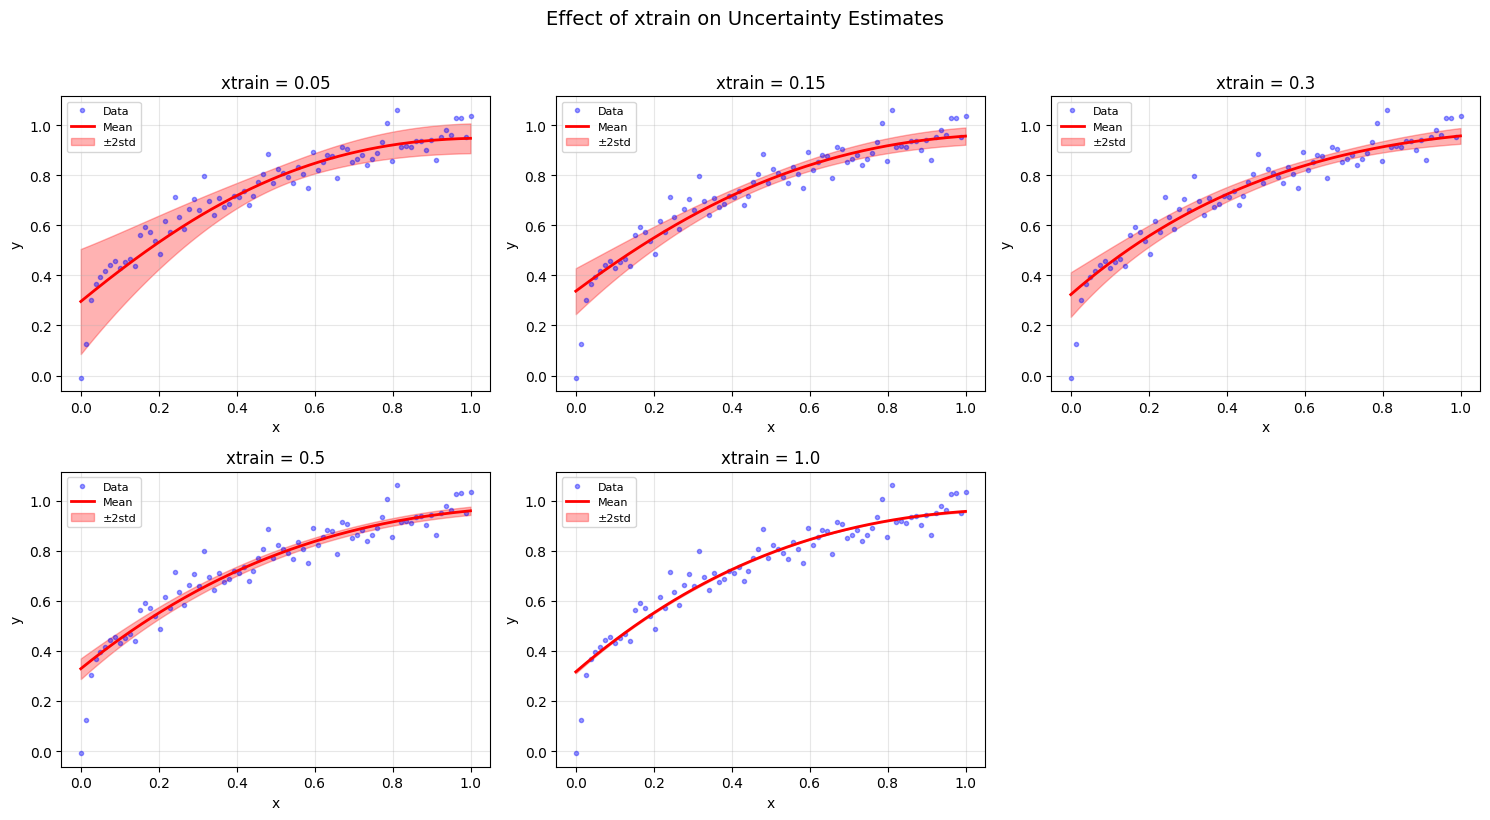


Observations:
- Small xtrain (0.05): Wide uncertainty bands - each neuron sees little data
- Medium xtrain (0.15-0.3): Balanced uncertainty
- Large xtrain (1.0): Narrow uncertainty - all neurons see all data


In [9]:
# Visualize effect of xtrain
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

x_dense = jnp.linspace(0, 1, 200)[:, None]

for idx, xt in enumerate(xtrain_values):
    ax = axes[idx]

    # Get predictions
    y_pred, y_std = models[xt].predict(x_dense, return_std=True)

    # Plot
    ax.plot(x, y, "b.", alpha=0.4, label="Data")
    ax.plot(x_dense, y_pred, "r-", linewidth=2, label="Mean")
    ax.fill_between(
        x_dense.flatten(),
        y_pred - 2 * y_std,
        y_pred + 2 * y_std,
        alpha=0.3,
        color="red",
        label="±2std",
    )

    ax.set_title(f"xtrain = {xt}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide the 6th subplot
axes[5].axis("off")

plt.suptitle("Effect of xtrain on Uncertainty Estimates", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Small xtrain (0.05): Wide uncertainty bands - each neuron sees little data")
print("- Medium xtrain (0.15-0.3): Balanced uncertainty")
print("- Large xtrain (1.0): Narrow uncertainty - all neurons see all data")

## Example 3: Uncertainty Quantification - Prediction Intervals

Let's verify that the uncertainty estimates capture the true data variability.

In [10]:
# Generate test data with same noise level
x_test_dense = jnp.linspace(0, 1, 100)[:, None]
y_test_true = x_test_dense ** (1 / 3)
key_test = jax.random.PRNGKey(123)
y_test_noisy = y_test_true + 0.05 * jax.random.normal(key_test, x_test_dense.shape)
y_test_noisy = y_test_noisy.flatten()

# Get predictions with uncertainty
model_uq = KfoldNN(layers=(1, 20, 30), xtrain=0.12, seed=42)
model_uq.fit(x, y, maxiter=1000, tol=1e-4)

y_pred, y_std = model_uq.predict(x_test_dense, return_std=True)

# Calculate coverage (fraction of points within ±2std)
lower_bound = y_pred - 2 * y_std
upper_bound = y_pred + 2 * y_std

within_interval = jnp.logical_and(y_test_noisy >= lower_bound, y_test_noisy <= upper_bound)
coverage = jnp.mean(within_interval)

print(f"95% Confidence Interval Coverage: {coverage * 100:.1f}%")
print(f"(Target: ~95% for well-calibrated uncertainty)")
print(f"\nPoints within interval: {jnp.sum(within_interval)}/{len(y_test_noisy)}")

95% Confidence Interval Coverage: 72.0%
(Target: ~95% for well-calibrated uncertainty)

Points within interval: 72/100


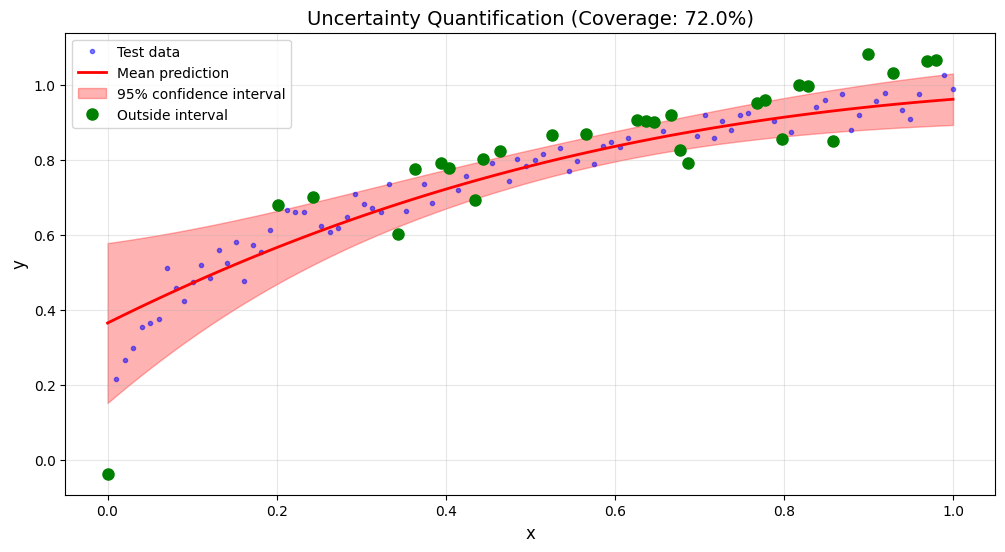

In [11]:
# Visualize uncertainty and coverage
plt.figure(figsize=(12, 6))

# Plot predictions and intervals
plt.plot(x_test_dense, y_test_noisy, "b.", alpha=0.5, label="Test data")
plt.plot(x_test_dense, y_pred, "r-", linewidth=2, label="Mean prediction")
plt.fill_between(
    x_test_dense.flatten(),
    lower_bound,
    upper_bound,
    alpha=0.3,
    color="red",
    label="95% confidence interval",
)

# Highlight points outside interval
outside = ~within_interval
if jnp.any(outside):
    plt.plot(
        x_test_dense[outside], y_test_noisy[outside], "go", markersize=8, label="Outside interval"
    )

plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"Uncertainty Quantification (Coverage: {coverage * 100:.1f}%)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## Example 4: Extrapolation Detection

One key application of UQ is detecting when the model is extrapolating beyond the training domain. Uncertainty should increase outside the training region.

In [12]:
# Train on limited domain [0.2, 0.8]
x_limited = jnp.linspace(0.2, 0.8, 60)[:, None]
key_lim = jax.random.PRNGKey(456)
y_limited = x_limited ** (1 / 3) + 0.05 * jax.random.normal(key_lim, x_limited.shape)
y_limited = y_limited.flatten()

# Train model
model_extrap = KfoldNN(layers=(1, 15, 25), xtrain=0.1, seed=42)
model_extrap.fit(x_limited, y_limited, maxiter=800)

print("Model trained on domain [0.2, 0.8]")
print(f"Training R² score: {model_extrap.score(x_limited, y_limited):.4f}")

Model trained on domain [0.2, 0.8]
Training R² score: 0.7539


In [13]:
# Test on extended domain [-0.2, 1.2]
x_extended = jnp.linspace(-0.2, 1.2, 200)[:, None]
y_pred_ext, y_std_ext = model_extrap.predict(x_extended, return_std=True)

# Calculate mean uncertainty in different regions
interp_mask = (x_extended >= 0.2) & (x_extended <= 0.8)
extrap_mask = ~interp_mask.flatten()

mean_std_interp = jnp.mean(y_std_ext[interp_mask.flatten()])
mean_std_extrap = jnp.mean(y_std_ext[extrap_mask])

print("\nUncertainty Analysis:")
print(f"Mean uncertainty in interpolation region [0.2, 0.8]: {mean_std_interp:.4f}")
print(f"Mean uncertainty in extrapolation regions: {mean_std_extrap:.4f}")
print(f"Uncertainty ratio (extrap/interp): {mean_std_extrap / mean_std_interp:.2f}x")


Uncertainty Analysis:
Mean uncertainty in interpolation region [0.2, 0.8]: 0.0328
Mean uncertainty in extrapolation regions: 0.0659
Uncertainty ratio (extrap/interp): 2.01x


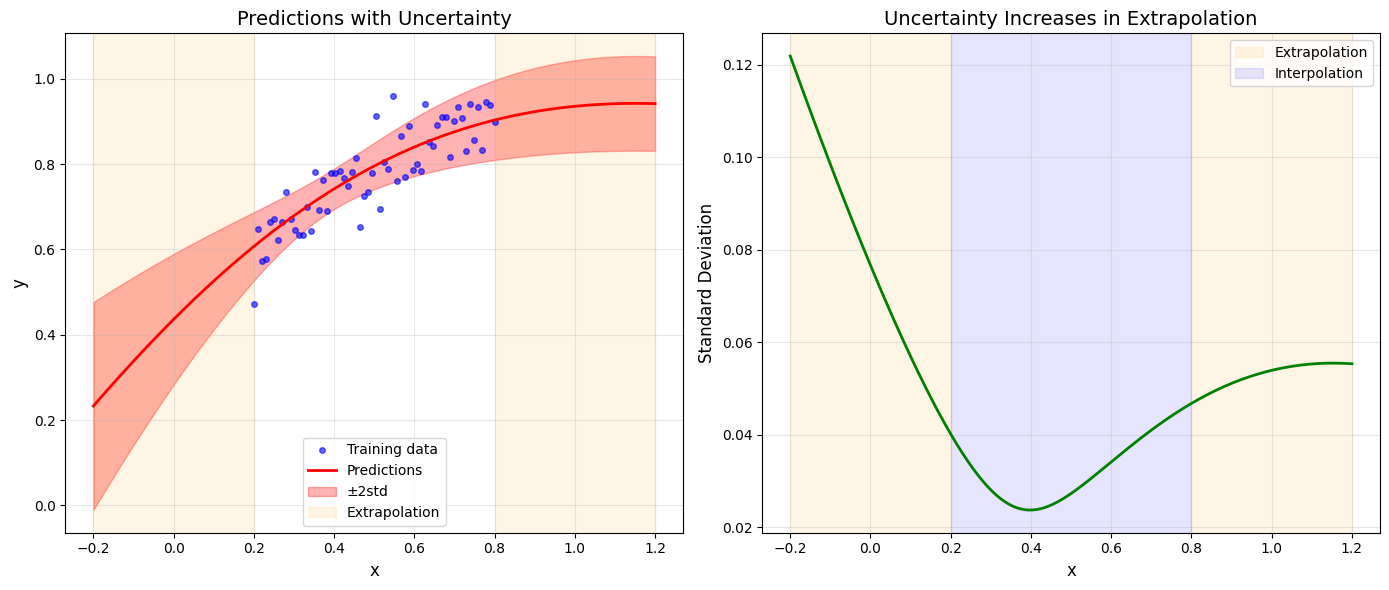


✓ Uncertainty successfully detects extrapolation!


In [14]:
# Visualize extrapolation uncertainty
plt.figure(figsize=(14, 6))

# Plot predictions
plt.subplot(1, 2, 1)
plt.plot(x_limited, y_limited, "b.", alpha=0.6, label="Training data", markersize=8)
plt.plot(x_extended, y_pred_ext, "r-", linewidth=2, label="Predictions")
plt.fill_between(
    x_extended.flatten(),
    y_pred_ext - 2 * y_std_ext,
    y_pred_ext + 2 * y_std_ext,
    alpha=0.3,
    color="red",
    label="±2std",
)
plt.axvspan(-0.2, 0.2, alpha=0.1, color="orange", label="Extrapolation")
plt.axvspan(0.8, 1.2, alpha=0.1, color="orange")
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title("Predictions with Uncertainty", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot uncertainty alone
plt.subplot(1, 2, 2)
plt.plot(x_extended, y_std_ext, "g-", linewidth=2)
plt.axvspan(-0.2, 0.2, alpha=0.1, color="orange", label="Extrapolation")
plt.axvspan(0.8, 1.2, alpha=0.1, color="orange")
plt.axvspan(0.2, 0.8, alpha=0.1, color="blue", label="Interpolation")
plt.xlabel("x", fontsize=12)
plt.ylabel("Standard Deviation", fontsize=12)
plt.title("Uncertainty Increases in Extrapolation", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Uncertainty successfully detects extrapolation!")

## Example 5: Accessing the Full Prediction Distribution

The `__call__` interface with `distribution=True` gives access to all individual neuron predictions.

In [15]:
# Get full distribution at a single point
x_point = jnp.array([[0.5]])

# Get mean prediction
y_mean = model(x_point)
print(f"Mean prediction: {y_mean[0]:.4f}")

# Get full distribution (all 25 neuron predictions)
y_dist = model(x_point, distribution=True)
print(f"\nDistribution shape: {y_dist.shape}")
print(f"All {y_dist.shape[1]} neuron predictions:")
print(y_dist.flatten()[:10], "...")  # Show first 10

# Statistics of the distribution
print(f"\nDistribution statistics:")
print(f"  Mean: {jnp.mean(y_dist):.4f}")
print(f"  Std:  {jnp.std(y_dist):.4f}")
print(f"  Min:  {jnp.min(y_dist):.4f}")
print(f"  Max:  {jnp.max(y_dist):.4f}")

Mean prediction: 0.7839

Distribution shape: (1, 25)
All 25 neuron predictions:
[0.801069   0.76733413 0.79084422 0.76566346 0.78851772 0.80195466
 0.79990912 0.79092015 0.78696861 0.76557706] ...

Distribution statistics:
  Mean: 0.7839
  Std:  0.0164
  Min:  0.7300
  Max:  0.8082


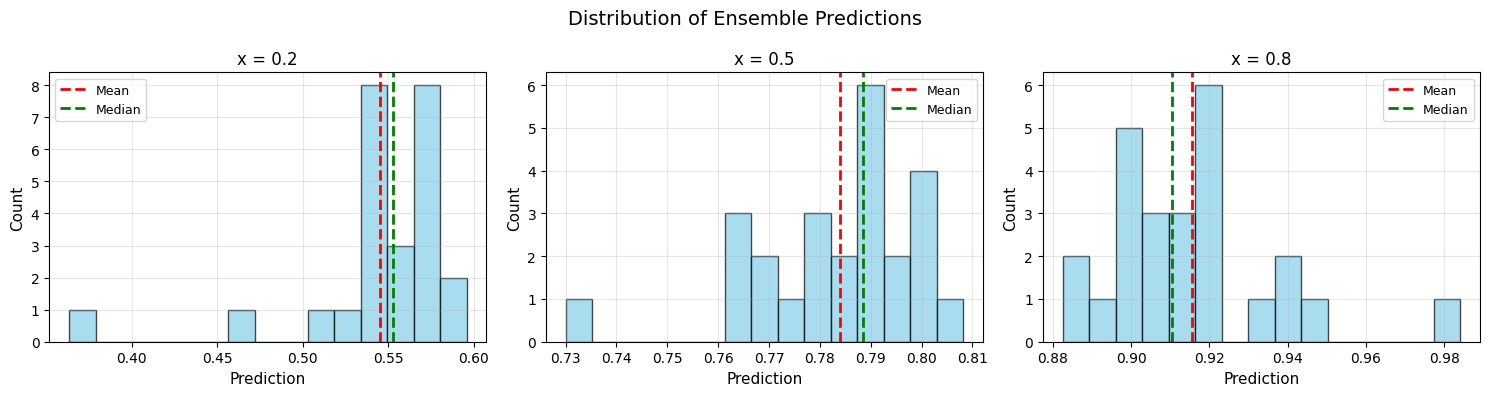

In [16]:
# Visualize distribution for multiple points
x_sample = jnp.array([[0.2], [0.5], [0.8]])
y_distributions = model(x_sample, distribution=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (xi, ax) in enumerate(zip(x_sample, axes)):
    dist = y_distributions[i, :]

    # Histogram of predictions
    ax.hist(dist, bins=15, alpha=0.7, color="skyblue", edgecolor="black")
    ax.axvline(jnp.mean(dist), color="red", linestyle="--", linewidth=2, label="Mean")
    ax.axvline(jnp.median(dist), color="green", linestyle="--", linewidth=2, label="Median")

    ax.set_xlabel("Prediction", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_title(f"x = {xi[0]:.1f}", fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Distribution of Ensemble Predictions", fontsize=14)
plt.tight_layout()
plt.show()

## Example 6: Network Architecture Comparison

Let's compare different network architectures and see how they affect performance.

In [17]:
# Define different architectures
architectures = {
    "Small": (1, 10, 15),
    "Medium": (1, 20, 25),
    "Large": (1, 30, 35),
    "Deep": (1, 15, 20, 25, 20),
}

arch_models = {}

for name, layers in architectures.items():
    print(f"Training {name} architecture: {layers}")
    m = KfoldNN(layers=layers, xtrain=0.15, seed=42)
    m.fit(x, y, maxiter=600, tol=1e-3)
    arch_models[name] = m
    info = m.report()
    r2 = m.score(x, y)
    print(f"  R²: {r2:.4f}, Loss: {info['final_loss']:.4f}\n")

Training Small architecture: (1, 10, 15)
Iterations: 600, Loss: 0.088827
  R²: 0.9007, Loss: 0.0888

Training Medium architecture: (1, 20, 25)
Iterations: 600, Loss: 0.130560
  R²: 0.9086, Loss: 0.1306

Training Large architecture: (1, 30, 35)
Iterations: 600, Loss: 0.203580
  R²: 0.9086, Loss: 0.2036

Training Deep architecture: (1, 15, 20, 25, 20)
Iterations: 600, Loss: 0.099121
  R²: 0.9156, Loss: 0.0991



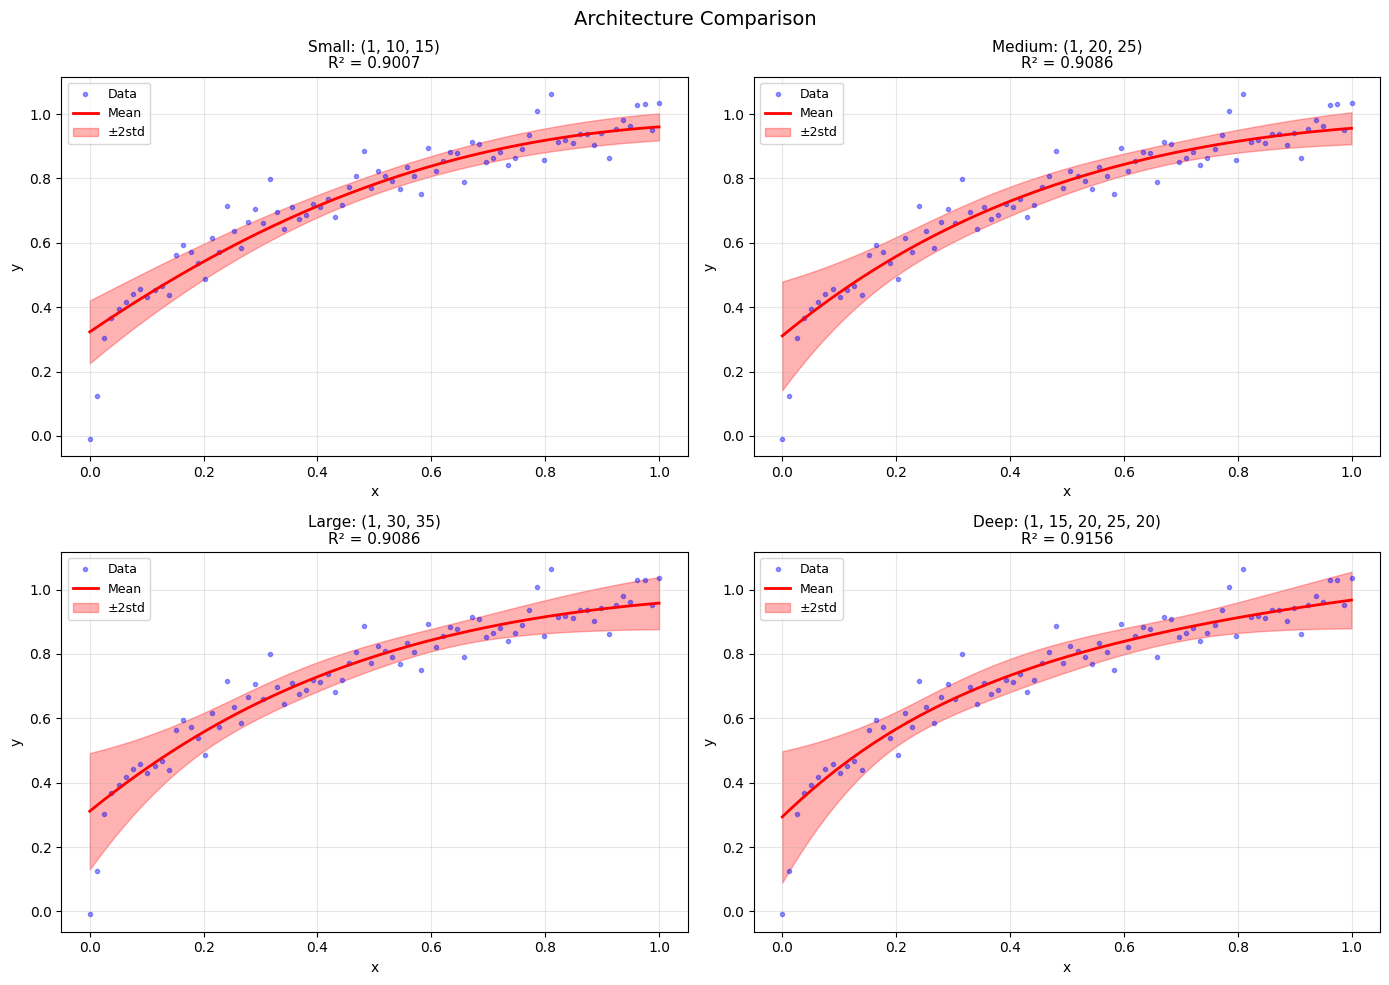


Observation: All architectures perform well, but larger networks 
may provide slightly better fits. Choose based on data complexity.


In [18]:
# Compare architectures visually
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

x_plot = jnp.linspace(0, 1, 150)[:, None]

for idx, (name, m) in enumerate(arch_models.items()):
    ax = axes[idx]

    # Predictions
    y_pred, y_std = m.predict(x_plot, return_std=True)

    # Plot
    ax.plot(x, y, "b.", alpha=0.4, markersize=6, label="Data")
    ax.plot(x_plot, y_pred, "r-", linewidth=2, label="Mean")
    ax.fill_between(
        x_plot.flatten(),
        y_pred - 2 * y_std,
        y_pred + 2 * y_std,
        alpha=0.3,
        color="red",
        label="±2std",
    )

    r2 = m.score(x, y)
    ax.set_title(f"{name}: {architectures[name]}\nR² = {r2:.4f}", fontsize=11)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(loc="upper left", fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Architecture Comparison", fontsize=14)
plt.tight_layout()
plt.show()

print("\nObservation: All architectures perform well, but larger networks ")
print("may provide slightly better fits. Choose based on data complexity.")

## Example 7: 2D Input Problem - Surface Fitting

K-fold NN works with multi-dimensional inputs. Let's fit a 2D surface.

In [19]:
# Generate 2D data: z = x^2 + y^2 + noise
np.random.seed(42)
n_samples = 150
X_2d = np.random.uniform(-1, 1, size=(n_samples, 2))
z_true = X_2d[:, 0] ** 2 + X_2d[:, 1] ** 2
z = z_true + 0.05 * np.random.randn(n_samples)

print(f"2D dataset: {n_samples} samples")
print(f"X shape: {X_2d.shape}")
print(f"z shape: {z.shape}")

2D dataset: 150 samples
X shape: (150, 2)
z shape: (150,)


In [20]:
# Train 2D model
model_2d = KfoldNN(layers=(2, 20, 30, 25), xtrain=0.15, seed=42)
model_2d.fit(X_2d, z, maxiter=1000, tol=1e-4)

print(model_2d)
print()
info_2d = model_2d.report()
r2_2d = model_2d.score(X_2d, z)
print(f"\nR² score: {r2_2d:.4f}")

K-fold Neural Network (fitted)
  Architecture: (2, 20, 30, 25)
  Hidden layers: 3
  Output neurons: 25
  Training fraction: 0.15
  Iterations: 1000
  Final loss: 0.146772

Iterations: 1000, Loss: 0.146772

R² score: 0.9812


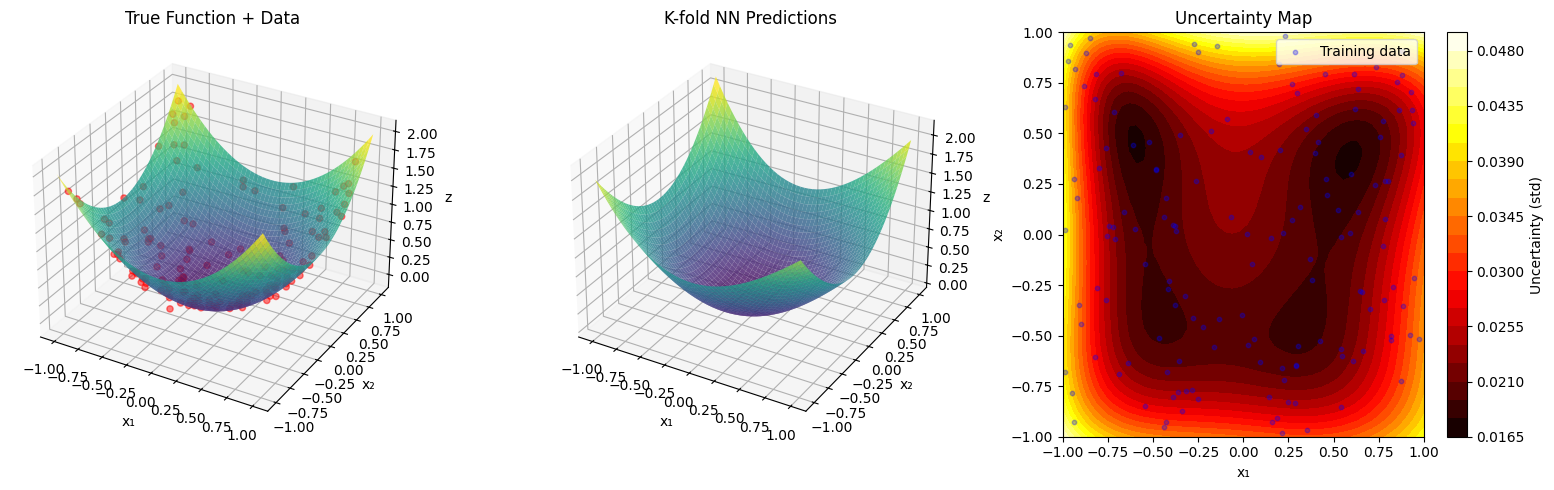


✓ K-fold NN successfully handles multi-dimensional inputs!


In [21]:
# Create grid for visualization
x1_grid = np.linspace(-1, 1, 50)
x2_grid = np.linspace(-1, 1, 50)
X1_mesh, X2_mesh = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack([X1_mesh.ravel(), X2_mesh.ravel()])

# Predictions
z_pred, z_std = model_2d.predict(X_grid, return_std=True)
Z_pred_mesh = z_pred.reshape(X1_mesh.shape)
Z_std_mesh = z_std.reshape(X1_mesh.shape)

# Visualize
fig = plt.figure(figsize=(16, 5))

# True function
ax1 = fig.add_subplot(131, projection="3d")
Z_true_mesh = X1_mesh**2 + X2_mesh**2
surf1 = ax1.plot_surface(X1_mesh, X2_mesh, Z_true_mesh, cmap="viridis", alpha=0.8)
ax1.scatter(X_2d[:, 0], X_2d[:, 1], z, c="red", s=20, alpha=0.5)
ax1.set_title("True Function + Data", fontsize=12)
ax1.set_xlabel("x₁")
ax1.set_ylabel("x₂")
ax1.set_zlabel("z")

# Predictions
ax2 = fig.add_subplot(132, projection="3d")
surf2 = ax2.plot_surface(X1_mesh, X2_mesh, Z_pred_mesh, cmap="viridis", alpha=0.8)
ax2.set_title("K-fold NN Predictions", fontsize=12)
ax2.set_xlabel("x₁")
ax2.set_ylabel("x₂")
ax2.set_zlabel("z")

# Uncertainty
ax3 = fig.add_subplot(133)
contour = ax3.contourf(X1_mesh, X2_mesh, Z_std_mesh, levels=20, cmap="hot")
ax3.scatter(X_2d[:, 0], X_2d[:, 1], c="blue", s=10, alpha=0.3, label="Training data")
plt.colorbar(contour, ax=ax3, label="Uncertainty (std)")
ax3.set_title("Uncertainty Map", fontsize=12)
ax3.set_xlabel("x₁")
ax3.set_ylabel("x₂")
ax3.legend()

plt.tight_layout()
plt.show()

print("\n✓ K-fold NN successfully handles multi-dimensional inputs!")

## Example 8: Model Persistence - Saving and Loading

You can save trained models using pickle or dill.

In [22]:
import pickle
import tempfile
import os

# Train a model
model_save = KfoldNN(layers=(1, 15, 20), xtrain=0.1, seed=42)
model_save.fit(x[:50], y[:50], maxiter=500)

print("Original model:")
print(model_save)
original_pred = model_save.predict(jnp.array([[0.5]]))
print(f"\nPrediction at x=0.5: {original_pred[0]:.4f}")

Original model:
K-fold Neural Network (fitted)
  Architecture: (1, 15, 20)
  Hidden layers: 2
  Output neurons: 20
  Training fraction: 0.10
  Iterations: 500
  Final loss: 0.068130

Prediction at x=0.5: 0.7939


In [23]:
# Save model
with tempfile.TemporaryDirectory() as tmpdir:
    model_path = os.path.join(tmpdir, "kfoldnn_model.pkl")

    # Save
    with open(model_path, "wb") as f:
        pickle.dump(model_save, f)

    print(f"\nModel saved to: {model_path}")
    print(f"File size: {os.path.getsize(model_path) / 1024:.2f} KB")

    # Load
    with open(model_path, "rb") as f:
        model_loaded = pickle.load(f)

    print("\nLoaded model:")
    print(model_loaded)

    # Verify predictions match
    loaded_pred = model_loaded.predict(jnp.array([[0.5]]))
    print(f"\nPrediction at x=0.5: {loaded_pred[0]:.4f}")
    print(f"Match: {jnp.allclose(original_pred, loaded_pred)}")

print("\n✓ Model successfully saved and loaded!")


Model saved to: /var/folders/gq/k1kgbl7n539_4dl1md8x3jt80000gn/T/tmpl0o_gei8/kfoldnn_model.pkl
File size: 32.71 KB

Loaded model:
K-fold Neural Network (fitted)
  Architecture: (1, 15, 20)
  Hidden layers: 2
  Output neurons: 20
  Training fraction: 0.10
  Iterations: 500
  Final loss: 0.068130

Prediction at x=0.5: 0.7939
Match: True

✓ Model successfully saved and loaded!


## Example 9: Active Learning Simulation

Use uncertainty to guide sampling in active learning.

In [24]:
# Start with sparse initial data
n_initial = 10
x_pool = jnp.linspace(0, 1, 100)[:, None]  # Pool of candidate points
key_al = jax.random.PRNGKey(789)

# Initial random sample
initial_idx = np.random.choice(len(x_pool), n_initial, replace=False)
x_train_al = x_pool[initial_idx]
y_train_al = (x_train_al ** (1 / 3) + 0.05 * jax.random.normal(key_al, x_train_al.shape)).flatten()

# Simulate active learning iterations
n_iterations = 5
n_select = 5  # Select 5 points per iteration

results_al = []

for iteration in range(n_iterations):
    # Train model on current data
    model_al = KfoldNN(layers=(1, 15, 20), xtrain=0.1, seed=42)
    model_al.fit(x_train_al, y_train_al, maxiter=400, tol=1e-3)

    # Get uncertainty for all pool points
    _, uncertainty = model_al.predict(x_pool, return_std=True)

    # Select points with highest uncertainty
    selected_idx = jnp.argsort(uncertainty)[-n_select:]
    x_new = x_pool[selected_idx]
    y_new = (x_new ** (1 / 3) + 0.05 * jax.random.normal(key_al, x_new.shape)).flatten()

    # Add to training set
    x_train_al = jnp.vstack([x_train_al, x_new])
    y_train_al = jnp.concatenate([y_train_al, y_new])

    # Record results
    r2 = model_al.score(x_train_al, y_train_al)
    results_al.append(
        {
            "iteration": iteration,
            "n_samples": len(x_train_al),
            "r2": r2,
            "mean_uncertainty": jnp.mean(uncertainty),
        }
    )

    print(f"Iteration {iteration}: {len(x_train_al)} samples, R² = {r2:.4f}")

print("\n✓ Active learning complete!")

Iteration 0: 15 samples, R² = 0.6976
Iteration 1: 20 samples, R² = 0.8302
Iteration 2: 25 samples, R² = 0.8994
Iteration 3: 30 samples, R² = 0.9080
Iteration 4: 35 samples, R² = 0.9157

✓ Active learning complete!


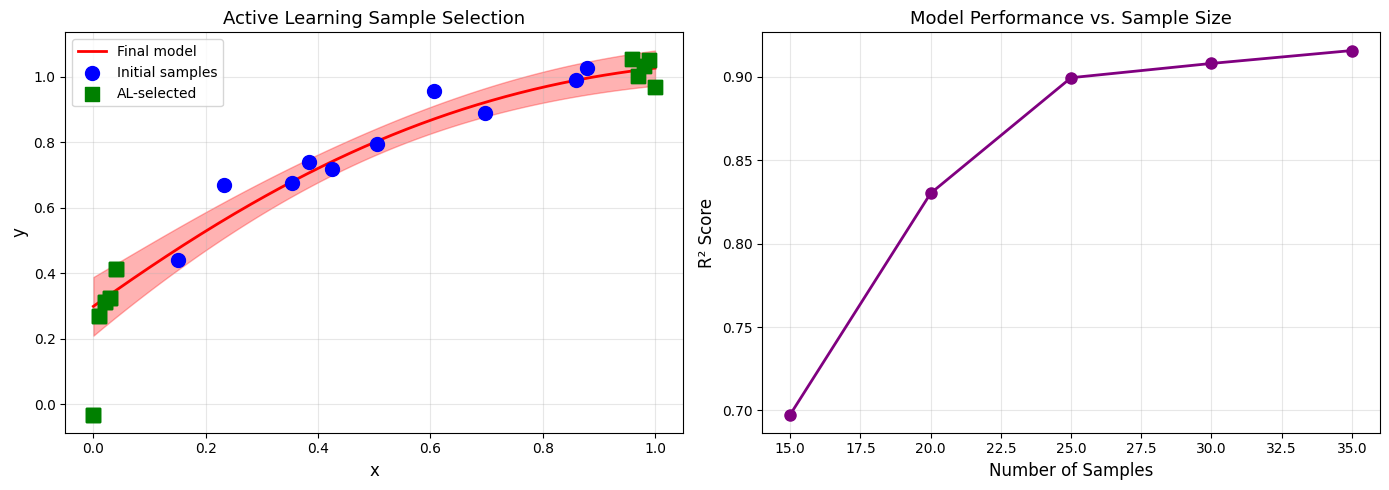


Started with 10 samples, ended with 35 samples
Final R² score: 0.9157


In [25]:
# Visualize active learning progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sample selection over iterations
ax1 = axes[0]
x_plot_al = jnp.linspace(0, 1, 200)[:, None]
y_pred_al, y_std_al = model_al.predict(x_plot_al, return_std=True)

ax1.plot(x_plot_al, y_pred_al, "r-", linewidth=2, label="Final model")
ax1.fill_between(
    x_plot_al.flatten(), y_pred_al - 2 * y_std_al, y_pred_al + 2 * y_std_al, alpha=0.3, color="red"
)
ax1.scatter(
    x_train_al[:n_initial],
    y_train_al[:n_initial],
    c="blue",
    s=100,
    marker="o",
    label="Initial samples",
    zorder=5,
)
ax1.scatter(
    x_train_al[n_initial:],
    y_train_al[n_initial:],
    c="green",
    s=100,
    marker="s",
    label="AL-selected",
    zorder=5,
)
ax1.set_xlabel("x", fontsize=12)
ax1.set_ylabel("y", fontsize=12)
ax1.set_title("Active Learning Sample Selection", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Performance over iterations
ax2 = axes[1]
iterations = [r["iteration"] for r in results_al]
n_samples = [r["n_samples"] for r in results_al]
r2_scores = [r["r2"] for r in results_al]

ax2.plot(n_samples, r2_scores, "o-", linewidth=2, markersize=8, color="purple")
ax2.set_xlabel("Number of Samples", fontsize=12)
ax2.set_ylabel("R² Score", fontsize=12)
ax2.set_title("Model Performance vs. Sample Size", fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStarted with {n_initial} samples, ended with {len(x_train_al)} samples")
print(f"Final R² score: {r2_scores[-1]:.4f}")

## Example 10: Best Practices & Tips

Summary of recommendations for using K-fold NN effectively.

### Choosing `xtrain`

**Guidelines:**
- **0.05-0.15**: Wide uncertainty, good for exploration and detecting outliers
- **0.15-0.3**: Balanced, recommended for most applications
- **0.5-1.0**: Narrow uncertainty, use when you want conservative UQ

**Tip:** Start with 0.15 and adjust based on validation

### Network Architecture

**Number of hidden layers:**
- Simple problems: 1-2 hidden layers
- Complex problems: 2-4 hidden layers

**Hidden layer size:**
- Start with 15-30 neurons per layer
- Increase if underfitting

**Number of output neurons (k):**
- **15-25**: Good balance for most problems
- **25-50**: More stable uncertainty estimates
- More neurons = smoother uncertainty but slower training

### Training

**Iterations:**
- Default `maxiter=1500` usually sufficient
- Increase to 2000-3000 for complex problems
- Monitor convergence with `model.report()`

**Tolerance:**
- Default `tol=1e-3` works well
- Use `tol=1e-4` for higher precision

### When to Use K-fold NN

✅ **Good for:**
- Regression with uncertainty quantification
- Detecting extrapolation
- Active learning
- Small to medium datasets (< 10,000 samples)
- Smooth functions

❌ **Not ideal for:**
- Classification (use other UQ methods)
- Very large datasets (training can be slow)
- Real-time prediction (ensemble overhead)
- Highly discontinuous functions

### Interpreting Uncertainty

- **±2std ≈ 95% confidence interval** (for well-calibrated models)
- High uncertainty → Less confident predictions
- Low uncertainty → More confident predictions
- Uncertainty is **approximate**, not exact Bayesian credible intervals

### Performance Tips

1. **Data scaling**: Normalize inputs to [0, 1] or standardize for better training
2. **Warm starting**: Can call `fit()` multiple times to continue training
3. **Validation**: Always check UQ calibration on held-out data
4. **JAX acceleration**: Automatically uses GPU if available

### Example Workflow

```python
# 1. Create model
model = KfoldNN(layers=(n_features, 20, 25), xtrain=0.15)

# 2. Train
model.fit(X_train, y_train, maxiter=1000)

# 3. Check convergence
info = model.report()

# 4. Validate
r2_val = model.score(X_val, y_val)

# 5. Predict with uncertainty
y_pred, y_std = model.predict(X_test, return_std=True)

# 6. Check calibration
coverage = check_coverage(y_test, y_pred, y_std)
```

In [26]:
# Quick reference: Common model configurations

print("Common K-fold NN Configurations:\n")
print("Simple 1D problem:")
print("  KfoldNN(layers=(1, 15, 20), xtrain=0.15)")
print()
print("Complex 1D problem:")
print("  KfoldNN(layers=(1, 25, 35, 30), xtrain=0.12)")
print()
print("2D/3D problem:")
print("  KfoldNN(layers=(n_features, 30, 40, 30), xtrain=0.15)")
print()
print("High-dimensional (5-10 features):")
print("  KfoldNN(layers=(n_features, 50, 60, 40), xtrain=0.2)")
print()
print("Wide uncertainty for exploration:")
print("  KfoldNN(layers=(1, 15, 25), xtrain=0.05)")
print()
print("Narrow uncertainty (conservative):")
print("  KfoldNN(layers=(1, 15, 25), xtrain=0.8)")

Common K-fold NN Configurations:

Simple 1D problem:
  KfoldNN(layers=(1, 15, 20), xtrain=0.15)

Complex 1D problem:
  KfoldNN(layers=(1, 25, 35, 30), xtrain=0.12)

2D/3D problem:
  KfoldNN(layers=(n_features, 30, 40, 30), xtrain=0.15)

High-dimensional (5-10 features):
  KfoldNN(layers=(n_features, 50, 60, 40), xtrain=0.2)

Wide uncertainty for exploration:
  KfoldNN(layers=(1, 15, 25), xtrain=0.05)

Narrow uncertainty (conservative):
  KfoldNN(layers=(1, 15, 25), xtrain=0.8)


## Summary

We've covered:

1. ✅ **Basic usage** - Training and prediction with uncertainty
2. ✅ **xtrain parameter** - How it controls uncertainty width
3. ✅ **Uncertainty quantification** - Prediction intervals and calibration
4. ✅ **Extrapolation detection** - Identifying out-of-distribution inputs
5. ✅ **Distribution access** - Working with ensemble predictions
6. ✅ **Architecture comparison** - Choosing network size and depth
7. ✅ **Multi-dimensional inputs** - 2D surface fitting example
8. ✅ **Model persistence** - Saving and loading trained models
9. ✅ **Active learning** - Using uncertainty to guide sampling
10. ✅ **Best practices** - Guidelines and recommendations

### Next Steps

- Try K-fold NN on your own data
- Experiment with different `xtrain` values
- Compare with other UQ methods (Gaussian Processes, Quantile Regression, etc.)
- Check out the [pycse documentation](https://kitchingroup.cheme.cmu.edu/pycse/) for more examples

### References

- JAX: https://jax.readthedocs.io/
- Flax: https://flax.readthedocs.io/
- jaxopt: https://jaxopt.github.io/

---

**Happy modeling with uncertainty quantification!** 🎯